# Machine Learning in MusicBox

While MusicBox does not support machine learning directly, it is possible to feed in the model's output to a learner to create a generalized machine learning (ML) model.</br>
Machine learning involves the development of statistical algorithms that learn from existing data so that the model can be generalized to new data.</br>
This tutorial will go through a very basic example of running a simulation with the data being passed into a linear regression model as well as a random forest model.</br>
These models will attempt to predict some of the time steps of the simulation given a subset of the dataset not including the predicted time steps to prevent overfitting.</br>
Do note that both of the models that will be created are toy models and do not represent real-life situtations.

## 1. Importing Libraries

Below is a list of the required libraries for this tutorial:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from acom_music_box import MusicBox, Conditions
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2. Setting up and Solving the System

This code cell is a copy of the setup from the [Basic Workflow Tutorial](1.%20basic_workflow.ipynb), but with the evolving condition removed and the A parameter for the first reaction increased by a magnitude of 100 to induce a non-linear reaction.

In [2]:
# Create each of the species that will be simulated
X = mc.Species(name="X")
Y = mc.Species(name="Y")
Z = mc.Species(name="Z")
species = {"X": X, "Y": Y, "Z": Z}
gas = mc.Phase(name="gas", species=list(species.values()))
# Create the reactions that the species undergo in the
arr1 = mc.Arrhenius(name="X->Y", A=4.0e-1, C=50, reactants=[species["X"]], products=[species["Y"]], gas_phase=gas)
arr2 = mc.Arrhenius(name="Y->Z", A=4.0e-3, C=50, reactants=[species["Y"]], products=[species["Z"]], gas_phase=gas)
rxns = {"X->Y": arr1, "Y->Z": arr2}
# Create the mechanism that is defined by the species, phases, and reactions
mechanism = mc.Mechanism(name="tutorial_mechanism", species=list(species.values()), phases=[gas], reactions=list(rxns.values()))
# Create the box model that contains the mechanism
box_model = MusicBox()
box_model.load_mechanism(mechanism)
# Set the conditions of the box model at time = 0 s
box_model.initial_conditions = Conditions(
    temperature=298.15, # Units: Kelvin (K)
    pressure=101325.0, # Units: Pascals (Pa)
    species_concentrations={ # Units: mol/m^3
        "X": 3.75,
        "Y": 5.0,
        "Z": 2.5,
    }
)
# Set the additional configuration options for the box model
box_model.box_model_options.simulation_length = 199 # Units: Seconds (s)
box_model.box_model_options.chem_step_time = 1 # Units: Seconds (s)
box_model.box_model_options.output_step_time = 1 # Units: Seconds (s)

df = box_model.solve()

display(df)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3
0,0.0,298.15,101325.0,40.874045,3.750000e+00,5.000000,2.500000
1,1.0,298.15,101325.0,40.874045,2.336557e+00,6.386248,2.527194
2,2.0,298.15,101325.0,40.874045,1.455834e+00,7.234592,2.559574
3,3.0,298.15,101325.0,40.874045,9.070407e-01,7.747848,2.595111
4,4.0,298.15,101325.0,40.874045,5.650710e-01,8.052385,2.632544
...,...,...,...,...,...,...,...
195,195.0,298.15,101325.0,40.874045,3.129731e-40,3.493691,7.756309
196,196.0,298.15,101325.0,40.874045,1.949733e-40,3.477204,7.772796
197,197.0,298.15,101325.0,40.874045,1.214628e-40,3.460794,7.789206
198,198.0,298.15,101325.0,40.874045,7.566784e-41,3.444462,7.805538


## 3. Creating the Future Time Steps

In order to build the ML model, it needs an expected output for every input for each of the species' concentrations.</br>
To achieve this, three new columns are made to represent the reaction one time step ahead of the current time step.</br>
When the model is constructed, it will attempt to predict the values one time step ahead from the values at the current time step.</br>
However, you can increase the number of time steps you wish to predict ahead by changing the <i>shift_value</i> to be a larger negative number.</br>
For example, a <i>shift_value</i> of -5 means the model will predict the concentrations five time steps ahead for every step.</br>
There is a fourth column also added called <i>dt</i>, which simply represents the time step length which will be fed into the model as an independent variable.</br>
Lastly, since the model is trying to predict the future, there will be time steps at the end where there will be no future concentrations since the simulation ended, thus leading to a NaN value.</br>
These rows at the end are all dropped to prevent these incomplete rows from being added to the model.

In [3]:
shift_value = -1

df['CONC.X.mol m-3 t+1'] = df['CONC.X.mol m-3'].shift(shift_value)
df['CONC.Y.mol m-3 t+1'] = df['CONC.Y.mol m-3'].shift(shift_value)
df['CONC.Z.mol m-3 t+1'] = df['CONC.Z.mol m-3'].shift(shift_value)

# 'dt' represents the time step length, repeat for every time step plus the original t=0 time step
df['dt'] = np.repeat(box_model.box_model_options.output_step_time, box_model.box_model_options.simulation_length + 1)

df = df.drop(df.index[shift_value:])

## 4. Normalizing the Concentrations

For many ML models, including linear regression, normalizing your data will ensure that each of the input and output features are weighted equally when they are not on the same scale initially.</br>
This is the case for the concentrations, where X drops all the way to 4e-41 while Y never goes below 3.4, a ginormous difference in scale.</br>
To normalize the data, a <i>MinMaxScaler()</i> is created which can alter the concentration columns in place with its <i>fit_transform()</i> function by taking in a column that is used to calcuate the normalized values.</br>
It should be noted that the t+1 columns are normalized based on the original concentration columns so that the normalization is kept consistent between the original column and the future time step column.</br>
The DataFrame is display before and after the normalization so that you can see how it alters the dataset.

In [4]:
scaler = MinMaxScaler()

display(df)

df['CONC.X.mol m-3'] = scaler.fit_transform(df[['CONC.X.mol m-3']])
df['CONC.X.mol m-3 t+1'] = scaler.fit_transform(df[['CONC.X.mol m-3']])
df['CONC.Y.mol m-3'] = scaler.fit_transform(df[['CONC.Y.mol m-3']])
df['CONC.Y.mol m-3 t+1'] = scaler.fit_transform(df[['CONC.Y.mol m-3']])
df['CONC.Z.mol m-3'] = scaler.fit_transform(df[['CONC.Z.mol m-3']])
df['CONC.Z.mol m-3 t+1'] = scaler.fit_transform(df[['CONC.Z.mol m-3']])

display(df)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3,CONC.X.mol m-3 t+1,CONC.Y.mol m-3 t+1,CONC.Z.mol m-3 t+1,dt
0,0.0,298.15,101325.0,40.874045,3.750000e+00,5.000000,2.500000,2.336557e+00,6.386248,2.527194,1
1,1.0,298.15,101325.0,40.874045,2.336557e+00,6.386248,2.527194,1.455834e+00,7.234592,2.559574,1
2,2.0,298.15,101325.0,40.874045,1.455834e+00,7.234592,2.559574,9.070407e-01,7.747848,2.595111,1
3,3.0,298.15,101325.0,40.874045,9.070407e-01,7.747848,2.595111,5.650710e-01,8.052385,2.632544,1
4,4.0,298.15,101325.0,40.874045,5.650710e-01,8.052385,2.632544,3.520230e-01,8.226891,2.671086,1
...,...,...,...,...,...,...,...,...,...,...,...
194,194.0,298.15,101325.0,40.874045,5.023877e-40,3.510257,7.739743,3.129731e-40,3.493691,7.756309,1
195,195.0,298.15,101325.0,40.874045,3.129731e-40,3.493691,7.756309,1.949733e-40,3.477204,7.772796,1
196,196.0,298.15,101325.0,40.874045,1.949733e-40,3.477204,7.772796,1.214628e-40,3.460794,7.789206,1
197,197.0,298.15,101325.0,40.874045,1.214628e-40,3.460794,7.789206,7.566784e-41,3.444462,7.805538,1


,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.X.mol m-3,CONC.Y.mol m-3,CONC.Z.mol m-3,CONC.X.mol m-3 t+1,CONC.Y.mol m-3 t+1,CONC.Z.mol m-3 t+1,dt
0,0.0,298.15,101325.0,40.874045,1.000000e+00,0.315454,0.000000,1.000000e+00,0.315454,0.000000,1
1,1.0,298.15,101325.0,40.874045,6.230820e-01,0.596577,0.005126,6.230820e-01,0.596577,0.005126,1
2,2.0,298.15,101325.0,40.874045,3.882224e-01,0.768617,0.011229,3.882224e-01,0.768617,0.011229,1
3,3.0,298.15,101325.0,40.874045,2.418775e-01,0.872702,0.017927,2.418775e-01,0.872702,0.017927,1
4,4.0,298.15,101325.0,40.874045,1.506856e-01,0.934460,0.024982,1.506856e-01,0.934460,0.024982,1
...,...,...,...,...,...,...,...,...,...,...,...
194,194.0,298.15,101325.0,40.874045,1.137920e-40,0.013343,0.987599,1.137920e-40,0.013343,0.987599,1
195,195.0,298.15,101325.0,40.874045,6.328142e-41,0.009983,0.990721,6.328142e-41,0.009983,0.990721,1
196,196.0,298.15,101325.0,40.874045,3.181479e-41,0.006640,0.993829,3.181479e-41,0.006640,0.993829,1
197,197.0,298.15,101325.0,40.874045,1.221199e-41,0.003312,0.996922,1.221199e-41,0.003312,0.996922,1


## 5. Defining the Independent and Dependent Variables

Next, the independent and dependent variables must be defined.</br>
For any ML model, your independent variables will be predicting the dependent variables</br>
For this model, the indepedent variables are:
* the temperature,
* the pressure,
* the time step length discussed in the previous step, and
* the three species' concentrations.

The dependent variables are each of the species' concentrations at the desired future time step (by default one time step into the future).

In [5]:
x = df[['ENV.temperature.K', 'ENV.pressure.Pa', 'dt', 'CONC.X.mol m-3', 'CONC.Y.mol m-3', 'CONC.Z.mol m-3']]
y = df[['CONC.X.mol m-3 t+1', 'CONC.Y.mol m-3 t+1', 'CONC.Z.mol m-3 t+1']]

## 6. Making the Train-Test Split for the Data

Once the independent and dependent variables are defined, they can each be split into training and testing data.</br>
Training data refers to the data that is fed into the model in order to fit it.</br>
For linear regression, this fit will be an equation of the form yx + b, where y represents the slope and b represents the y-intercept.</br>
On the other hand, the testing data is data that the model is blind to and will attempt to predict after being shown the training data.</br>
For this model, 80% of the data will be for training, and 20% will be for testing.</br>
Once the data is split, it is all sorted by index in order to make plotting the results much simpler; it does not affect the model.

In [6]:
# Split data into train/test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

## 7. Fitting, Predicting, and Evaluating the Model

With all the model preparation out of the way, it can now be created, fitted with the training data, and used to predict from the testing day.</br>
The with predicted y values calculated, the root mean square error (RMSE) and the correlation coefficient (R<sup>2</sup>) can be calculated.</br>
RMSE represents the average magnitude that a prediction is off.</br>
For example, a RMSE of 1 means the average concentration prediction is 1 mol/m<sup>3</sup> off from being correct.</br>
R<sup>2</sup> represents the percentage of variation in the dependent variables that is explained by the independent variables.</br>
For example, an R<sup>2</sup> of 0.5 means half of the variation in the dependent variables is explained by the independent variables.

In [7]:
# Train on training set
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {test_mse}")

r2 = r2_score(y_test, y_pred)
print(f"Coefficient of determination: {r2}")

Test RMSE: 3.0979901328417513e-16
Coefficient of determination: 1.0


## 8. Preparing the Predicted Data for Visualization

In its current state, the <i>y_pred</i> array cannot be visualized properly due to indexing issues; it only represents 20% of the original dataset, so 80% of the indices are missing.</br>
To fix this, the <i>y_pred</i> array is bundled into a DataFrame, taking the test indices as input initally.</br>
Then, the DataFrame is reindexed based on the original DataFrame's 200 indices. This will add back the missing indices with all NaN values, indicating that those time steps should not be plotted.</br>
The DataFrame is displayed before and after the reindexing so you can get an idea of what the <i>reindex()</i> function is doing.

In [8]:
conc_pred = pd.DataFrame(y_pred, index=y_test.index.tolist(), columns=['Predicted CONC.X.mol m-3', 'Predicted CONC.Y.mol m-3', 'Predicted CONC.Z.mol m-3'])
display(conc_pred)

conc_pred = conc_pred.reindex(df.index)
display(conc_pred)

,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
4,1.506856e-01,9.344605e-01,0.024982
9,1.413879e-02,9.984753e-01,0.061998
11,5.487169e-03,9.890398e-01,0.076882
17,3.207427e-04,9.456676e-01,0.120845
19,1.244781e-04,9.303343e-01,0.135235
22,3.009520e-05,9.074537e-01,0.156568
23,1.874845e-05,8.998835e-01,0.163612
34,1.028287e-07,8.188532e-01,0.238936
42,2.332700e-09,7.625049e-01,0.291308
46,3.513431e-10,7.351203e-01,0.316760


,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,1.506856e-01,9.344605e-01,0.024982
...,...,...,...
194,2.775558e-16,1.334271e-02,0.987599
195,NaN,NaN,NaN
196,NaN,NaN,NaN
197,NaN,NaN,NaN


## 9. Plot the Linear Regression Model

This code cell simply plots the three species' concentrations over time, with the predicted concentrations being scatterplots that represent the time steps present in the testing data.</br>
Due to the simplicity of this model, it is incredibly accurate, but traditional ML models will never reach this level of accuracy.

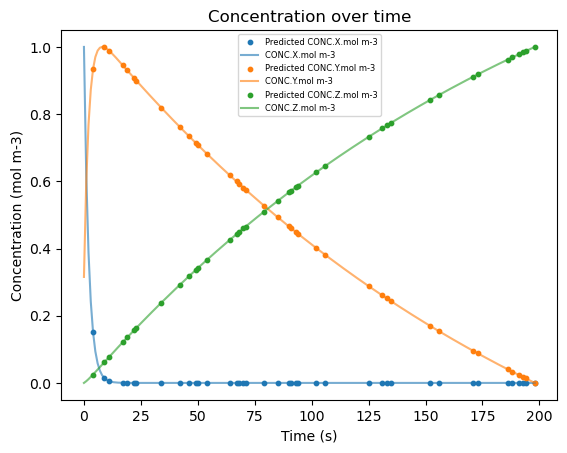

In [9]:
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.X.mol m-3'], label='Predicted CONC.X.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.X.mol m-3'], label='CONC.X.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Y.mol m-3'], label='Predicted CONC.Y.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Y.mol m-3 t+1'], label='CONC.Y.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Z.mol m-3'], label='Predicted CONC.Z.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Z.mol m-3 t+1'], label='CONC.Z.mol m-3', alpha=0.6)
plt.title('Concentration over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='upper center', fontsize=6)
plt.show()

## 10. Running and Evaluating the Random Forest Model

With the training and testing data already set up, there is not much work to get the random forest model running.</br>
The only new thing here is the addition of the <i>n_estimators</i> argument which defines the number of trees in the model. Feel free to change this number to experiment.</br>
As with the linear regression model, it is fitted based on the training data, ran on the testing data, and then evaluated against the ground truth.

In [10]:
# Train on training set
model = RandomForestRegressor(n_estimators=100)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {test_mse}")

r2 = r2_score(y_test, y_pred)
print(f"Coefficient of determination: {r2}")

Test RMSE: 0.002983709918343687
Coefficient of determination: 0.9988220102085813


## 11. Data Preparation for Visualization

This step is identical and achieves the same goal as step 8, refer to that step for an explanation.

In [11]:
conc_pred = pd.DataFrame(y_pred, index=y_test.index.tolist(), columns=['Predicted CONC.X.mol m-3', 'Predicted CONC.Y.mol m-3', 'Predicted CONC.Z.mol m-3'])
display(conc_pred)

conc_pred = conc_pred.reindex(df.index)
display(conc_pred)

,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
4,1.436981e-01,0.931116,0.033029
9,1.646325e-02,0.995199,0.063400
11,6.678594e-03,0.985372,0.079449
17,1.267018e-03,0.942454,0.123163
19,1.110294e-04,0.925375,0.139854
22,3.940581e-05,0.907650,0.156378
23,1.138828e-05,0.890030,0.172775
34,8.604256e-08,0.813647,0.243776
42,3.882227e-03,0.760327,0.290588
46,3.045705e-10,0.731075,0.320519


,Predicted CONC.X.mol m-3,Predicted CONC.Y.mol m-3,Predicted CONC.Z.mol m-3
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,1.436981e-01,0.931116,0.033029
...,...,...,...
194,9.368369e-41,0.009697,0.990988
195,NaN,NaN,NaN
196,NaN,NaN,NaN
197,NaN,NaN,NaN


## 12. Plot the Random Forest Model

This step is identical and achieves the same goal as step 9 but with the random forest model, refer to that step for an explanation.

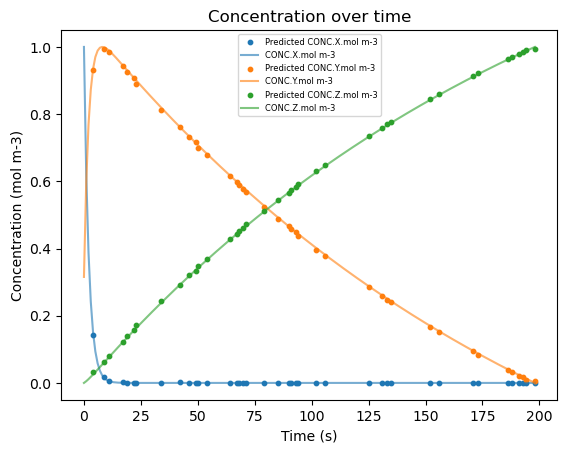

In [12]:
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.X.mol m-3'], label='Predicted CONC.X.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.X.mol m-3'], label='CONC.X.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Y.mol m-3'], label='Predicted CONC.Y.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Y.mol m-3 t+1'], label='CONC.Y.mol m-3', alpha=0.6)
plt.scatter(df.index.tolist(), conc_pred['Predicted CONC.Z.mol m-3'], label='Predicted CONC.Z.mol m-3', s=10)
plt.plot(df['time.s'], df['CONC.Z.mol m-3 t+1'], label='CONC.Z.mol m-3', alpha=0.6)
plt.title('Concentration over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend(loc='upper center', fontsize=6)
plt.show()